# Предсказание   дохода



Целью данной задачи является построение модели **классификации пользователей**: на вход модель будет принимать данные о человеке, а на выходе она должна предсказывать бинарный уровень дохода человека (больше или меньше 50000$ за год).

## Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#магическая команда, указывает, что графики нужно строить прямо в ноутбуке: 
%matplotlib inline 

In [ ]:
#!pip install comet_ml

In [41]:
from comet_ml import Experiment
import xgboost as xgb

In [3]:
#@title CometML set up
project_name = 'income-prediction'
workspace = 'nadarsa'
api_key = 'ComLI9KJBQ1k9FzhXktgCZvqZ'

In [4]:
experiment = Experiment(project_name=project_name, workspace=workspace, api_key = api_key, log_code=True)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.com/nadarsa/income-prediction/d3a558178b974f249988ce55c5673931



## Загрузка данных

In [5]:
%%capture
!wget https://www.dropbox.com/s/1hfrcm09qtvoeoz/train.csv
!wget https://www.dropbox.com/s/jj7c8r0x57zda0a/test.csv

SyntaxError: invalid decimal literal (1345729631.py, line 1)

In [6]:
training_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [7]:
training_data.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,49,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40,United-States,0
1,27,NaN,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,45,United-States,0
2,44,NaN,11th,Married-civ-spouse,Other-service,Husband,Black,Male,0.0,0.0,60,United-States,0
3,59,Private,Bachelors,Separated,Adm-clerical,Unmarried,White,Male,0.0,0.0,60,United-States,0
4,54,Private,Bachelors,Divorced,Sales,Not-in-family,White,Female,0.0,1408.0,38,United-States,0


Проверим размерности наших файлов:

In [8]:
training_data.shape, test_data.shape

((24420, 13), (8141, 13))

**Работаем с целевой переменной**



In [9]:
target_name = 'income'

In [10]:
y_train = training_data[target_name]
y_test = test_data[target_name]

X_train = training_data.drop(columns=[target_name])
X_test = test_data.drop(columns=[target_name])

**Оценка сбалансированности выборки**

In [11]:
y_train.value_counts(normalize=True)

0    0.757821
1    0.242179
Name: income, dtype: float64

Таким образом, имеем задачу **несбалансированной бинарной классификации**. 

## Общая статистика по числовым данным



In [13]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,24420.0,38.598116,13.638458,17.0,28.0,37.0,48.0,90.0
capital-gain,23705.0,1051.724067,7199.945441,0.0,0.0,0.0,0.0,99999.0
capital-loss,23936.0,88.409592,404.466154,0.0,0.0,0.0,0.0,4356.0
hours-per-week,24420.0,40.386568,12.299621,1.0,40.0,40.0,45.0,99.0


{'web': 'https://www.comet.com/api/image/download?imageId=4cc54c15da5248e788c3c5f04240dbb2&experimentKey=d3a558178b974f249988ce55c5673931',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=4cc54c15da5248e788c3c5f04240dbb2&experimentKey=d3a558178b974f249988ce55c5673931',
 'imageId': '4cc54c15da5248e788c3c5f04240dbb2'}

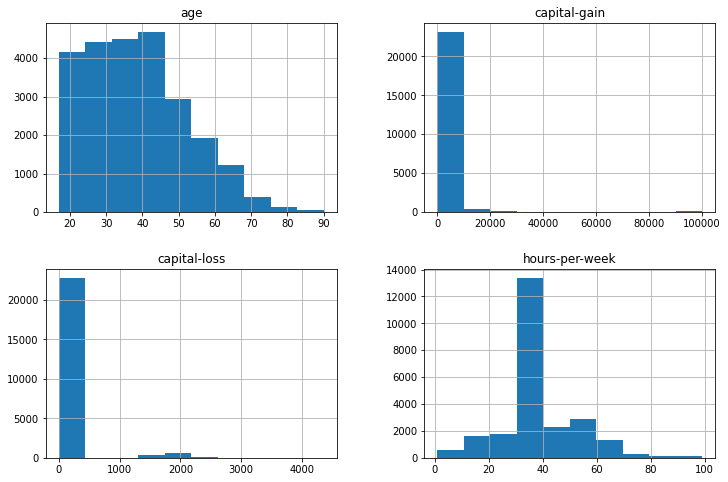

In [14]:
X_train.hist(figsize=(12,8))
experiment.log_figure('X_train_numeric_distr', plt)

Что мы можем увидеть из результатов?
* Числовых переменных в исходных данных только 4;
* Возраст пользователя варьируется в диапазоне от 17 до 90 лет и в среднем составляет 39 лет;
* Видим пропуски в признаках capital-gain и capital-loss (значение count меньше размера данных). По гистограмме можно заметить, что большое количество значений в этих признаках - это просто нули;

## Предобработка данных

### Проверка на наличие пропусков и типов переменных



In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24420 entries, 0 to 24419
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             24420 non-null  int64  
 1   workclass       23223 non-null  object 
 2   education       23443 non-null  object 
 3   marital-status  24420 non-null  object 
 4   occupation      24420 non-null  object 
 5   relationship    24420 non-null  object 
 6   race            24420 non-null  object 
 7   sex             24420 non-null  object 
 8   capital-gain    23705 non-null  float64
 9   capital-loss    23936 non-null  float64
 10  hours-per-week  24420 non-null  int64  
 11  native-country  24420 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 2.2+ MB


Типы в наших данных:
* 8 признаков типа **object** - обычно это строковые значения;
* 3 признака типа **int64** - целочисленные значения;
* 2 признака типа **float64** - числа с плавающей запятой. 

Кроме этого, мы видим, что признаки *workclass, education, capital-gain и capital-loss* имеют пропуски в данных.

### Обработка пропусков в данных

Далеко не все алгоритмы умеют работать с пропусками в данных. Кроме этого, удачно заполнив пропуски, мы сможем лучше восстановить распределение данных, а значит лучше построить моделей. 

Самые популярные методы для обработки пропусков:
- Удаление значений с пропусками (не желательно при большом количестве пропусков, потому что теряются данные);
- Заполнение средним/медианным значением;
- Заполненние самым частым значением;
- Заполнение случайным значением.

**Важно:** тестовую выборку мы всегда обрабатываем также, как и обучающую выборку. 

In [16]:
X_train['capital-loss'] = X_train['capital-loss'].fillna(0)
X_train['capital-gain'] = X_train['capital-gain'].fillna(0)

Сделаем то же самое для тестовой выборки:

In [17]:
X_test['capital-loss'] = X_test['capital-loss'].fillna(0)
X_test['capital-gain'] = X_test['capital-gain'].fillna(0)

In [18]:
X_train['workclass'].value_counts(True).head(1)

Private    0.696766
Name: workclass, dtype: float64

In [19]:
X_train['education'].value_counts(True).head(1)

HS-grad    0.322484
Name: education, dtype: float64

Наиболее частое значение признака **workclass** - Private, признака **education** - HS-grad. 

Теперь явно заполним пропуски:

In [20]:
X_train['workclass'] = X_train['workclass'].fillna('Private')
X_train['education'] = X_train['education'].fillna('HS-grad')

Сделаем то же самое для тестовой выборки:

In [21]:
X_test['workclass'] = X_test['workclass'].fillna('Private')
X_test['education'] = X_test['education'].fillna('HS-grad')

### Кодировка категориальных переменных

В данных 8 столбцов являются категориальными признаками. При чём в нашей задаче эти признаки **текстовые**. Машине сложно обрабатывать текстовые признаки, поэтому нам необходимо закодировать их, то есть преобразовать в числовые. 

Для начала необходимо выделить категорильные признаки:

In [23]:
categorical_features = ['workclass', 'education', 'marital-status', 
                        'occupation', 'relationship', 'race', 'sex', 
                        'native-country']

non_categorical_features = ['age', 'capital-gain', 'capital-loss', 
                            'hours-per-week']

Посмотрим на столбцы категориальных переменных:

In [24]:
X_train[categorical_features].head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
1,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States
2,Private,11th,Married-civ-spouse,Other-service,Husband,Black,Male,United-States
3,Private,Bachelors,Separated,Adm-clerical,Unmarried,White,Male,United-States
4,Private,Bachelors,Divorced,Sales,Not-in-family,White,Female,United-States


Мы рассмотрим два популярных метода кодирования категориальных признаков:
* Label Encoding, которому соответствует класс `LabelEncoder()` из библиотеки **sklearn**
* One Hot Encoding, которому соответствует класс `OneHotEncoder()` из библиотеки **sklearn**

**Label Encoding**



In [25]:
from sklearn.preprocessing import LabelEncoder

In [26]:
label_encoder = LabelEncoder()

In [27]:
X_train_le = X_train.copy()

In [28]:
X_test_le = X_test.copy()

In [29]:
for feature in categorical_features:
    X_train_le[feature] = label_encoder.fit_transform(X_train_le[feature])
    X_test_le[feature] = label_encoder.transform(X_test_le[feature])

In [30]:
X_train_le.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,49,4,11,2,3,0,4,1,0.0,0.0,40,39
1,27,4,11,2,7,0,4,1,0.0,0.0,45,39
2,44,4,1,2,8,0,2,1,0.0,0.0,60,39
3,59,4,9,5,1,4,4,1,0.0,0.0,60,39
4,54,4,9,0,12,1,4,0,0.0,1408.0,38,39


**One Hot Encoding**



In [31]:
from sklearn.preprocessing import OneHotEncoder

In [32]:
onehot_encoder = OneHotEncoder()

In [37]:
# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
X_train_onehot = onehot_encoder.fit_transform(X_train[categorical_features]).toarray()

# применяем полученное преобразование к тестовой выборке, результат переводим в массив
X_test_onehot = onehot_encoder.transform(X_test[categorical_features]).toarray()

# запишем полученные названия новых колонок в отдельную переменную
columns = onehot_encoder.get_feature_names(categorical_features)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [38]:
X_train_onehot = pd.DataFrame(X_train_onehot, columns=columns)
X_test_onehot = pd.DataFrame(X_test_onehot, columns=columns)

И наконец, запишем в новую переменную полученный результат, удалив все незакодированные категориальные признаки из новой таблицы. 

In [39]:
# соединяем новую табличку с исходной
X_train_new = pd.concat([X_train, X_train_onehot], axis=1)
X_test_new = pd.concat([X_test, X_test_onehot], axis=1)

# удаляем старые категориальные признаки
X_train_new = X_train_new.drop(columns=categorical_features)
X_test_new = X_test_new.drop(columns=categorical_features)

In [40]:
X_train_new.head()

,age,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,49,0.0,0.0,40,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,27,0.0,0.0,45,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,44,0.0,0.0,60,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,59,0.0,0.0,60,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,54,0.0,1408.0,38,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Обучение модели 

## Выбор метода обучения классификатора

Для обучения классификатора воспользуемся самым популярным алгоритмом машинного обучения - градиентным бустингом над решающими деревьями из библиотеки **xgboost**.

Градиентный бустинг над решающими деревьями имеет ряд преимуществ против других алгоритмов: 
* подходит сразу и для классификации, и для регрессии, и для задачи ранжирования;
* имеет высокую обобщающую способность;
* сложно допустить переобучение.

А основное достоинство реализации данного алгоритма в библиотеке **xgboost** - высокая вычислительная эффективность. 

In [42]:
from xgboost import XGBClassifier

Создаем прототип класса модели:

In [43]:
boosting_tree_model_oh = XGBClassifier(n_estimators=500, tree_method='gpu_hist', predictor='gpu_predictor')
boosting_tree_model_oh

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor='gpu_predictor',
              random_state=None, reg_alpha=None, reg_lambda=None, ...)

In [44]:
boosting_tree_model_le = XGBClassifier(n_estimators=500, tree_method='gpu_hist', predictor='gpu_predictor')
boosting_tree_model_le

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor='gpu_predictor',
              random_state=None, reg_alpha=None, reg_lambda=None, ...)

Наиболее важные гиперпараметры модели **XGBClassifier**:
* гиперпараметр **n_estimators** определяет, сколько деревьев использовать в модели
* гиперпараметр **max_depth** ограничивает максимальную глубину дерева

## Обучение модели на разных типах закодированных данных

In [45]:
boosting_tree_model_oh.fit(X_train_new, y_train)

XGBoostError: [15:44:44] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000014a50fc34 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000014a5b1180 xgboost::gbm::GBTree::ConfigureUpdaters() + 424
  [bt] (2) 3   libxgboost.dylib                    0x000000014a5b0d78 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > >, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > > > > const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000014a5cca20 xgboost::LearnerConfiguration::Configure() + 1016
  [bt] (4) 5   libxgboost.dylib                    0x000000014a5ccd40 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x000000014a5139a4 XGBoosterUpdateOneIter + 140
  [bt] (6) 7   libffi.dylib                        0x00000001cec68050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001cec70ae8 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-310-darwin.so       0x0000000103630350 _ctypes_callproc + 1396



In [46]:
boosting_tree_model_le.fit(X_train_le, y_train)

XGBoostError: [15:44:51] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000014a50fc34 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000014a5b1180 xgboost::gbm::GBTree::ConfigureUpdaters() + 424
  [bt] (2) 3   libxgboost.dylib                    0x000000014a5b0d78 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > >, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > > > > const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000014a5cca20 xgboost::LearnerConfiguration::Configure() + 1016
  [bt] (4) 5   libxgboost.dylib                    0x000000014a5ccd40 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x000000014a5139a4 XGBoosterUpdateOneIter + 140
  [bt] (6) 7   libffi.dylib                        0x00000001cec68050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001cec70ae8 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-310-darwin.so       0x0000000103630350 _ctypes_callproc + 1396



# Валидация модели на тестовой выборке

In [ ]:
prediction_boosting_oh = boosting_tree_model_oh.predict(X_test_new)

In [ ]:
np.unique(prediction_boosting_oh)

array([0, 1])

In [ ]:
# Сколько 1го класса присутсвует в предсказаниях?

In [ ]:
# Сколько 1го класса присутсвует в y_test?

## Точность предсказания

Посчитаем точность (**accuracy**) работы моделей. Напомним, что точность отражает, сколько в процентном соотношении от размера тестовой выборки модель угадала 1 и сколько угадала 0.

Функция для подсчета точности реализована в библиотеке **sklearn** и называется `accuracy_score()`.

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
acc_oh = accuracy_score(y_test, prediction_boosting_oh)

In [ ]:
experiment.log_metric('Accuracy OneHot data', acc_oh)

Сравним значения точности для наших моделей с точностью для константного классификатора, модели, которая всегда бы предсказывала больший класс, в нашем случае 0. Для этого можно в функцию `accuracy_score()` в качестве второго аргумента передать массив нулей такого же размера. Это делается с помощью функции `zeros_like()` из библиотеки **numpy**.

In [ ]:
print('Accuracy Major Class: ', accuracy_score(y_test, np.zeros_like(y_test)).round(3))

Accuracy Major Class:  0.763


In [ ]:
# Залогировать accuracy для LE

## Таблица сопряженности модели классификации

Другой способ оценивать качество работы классификатора - использовать таблицу сопряженности. 


|                   |  Предсказано `0` |  Предсказано `1` |
|:-------------------|:------------------|:------------------|
|**Фактически** `0`  |       TN         |       FP         |
|**Фактически** `1`  |       FN         |       TP         | 


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
pd.DataFrame(confusion_matrix(y_test, prediction_boosting_oh))

,0,1
0,5881,333
1,663,1264


In [ ]:
experiment.log_confusion_matrix(y_test, prediction_boosting_oh)

{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=811d139ac16c496ca18bedce9acaff29&experimentKey=debe4b2a28e249a9bcf70e20c2c256b8',
 'assetId': '811d139ac16c496ca18bedce9acaff29',
 'web': 'https://www.comet.ml/api/asset/download?assetId=811d139ac16c496ca18bedce9acaff29&experimentKey=debe4b2a28e249a9bcf70e20c2c256b8'}

## Прогноз вероятности принадлежности к классу

In [ ]:
pred_proba_boosting_oh = boosting_tree_model_oh.predict_proba(X_test_new)

In [ ]:
# Как выглядят предсказания?

array([[0.9907915 , 0.00920851],
       [0.3954633 , 0.6045367 ],
       [0.2793576 , 0.7206424 ],
       [0.9758066 , 0.02419338],
       [0.9899469 , 0.01005312]], dtype=float32)

In [ ]:
pred_proba_boosting = pred_proba_boosting_oh[:, 1]

Посмотрим на распределение предсказанной классификатором вероятности дохода > 50к, метки `1`.

{'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=60a2196ca6634687bd348a2da76c5b98&experimentKey=debe4b2a28e249a9bcf70e20c2c256b8',
 'imageId': '60a2196ca6634687bd348a2da76c5b98',
 'web': 'https://www.comet.ml/api/image/download?imageId=60a2196ca6634687bd348a2da76c5b98&experimentKey=debe4b2a28e249a9bcf70e20c2c256b8'}

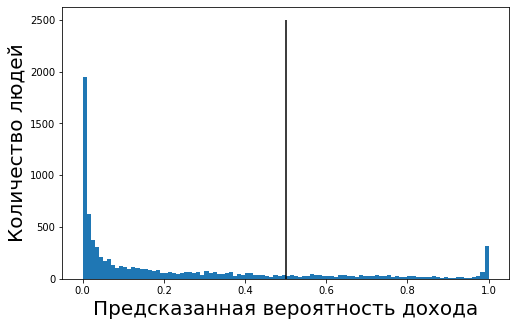

In [ ]:
plt.figure(figsize=(8, 5))

plt.hist(pred_proba_boosting, bins=100)
plt.vlines(0.5, 0, 2500)

plt.xlabel('Предсказанная вероятность дохода', fontsize=20)
plt.ylabel('Количество людей', fontsize=20)

experiment.log_figure('predicted_income_probability', plt)

##ROC кривая классификатора

Если хотят сравнить метрики на разных наборах данных, обычно работают не с абсолютными значениями True Positive и False Positive, а с их долями:

* Доля ложноположительных срабатываний $\text{FPR} = \frac{FP}{FP + TN}$;
* Доля истинно положительных срабатываний $\text{TPR} = \frac{TP}{TP + FN}$.

Заметим, что $FP + TN$ дает общее число объектов класса $0$, а $TP + FN$ - общее число объектов класса $1$. 

Одной из самых популярных метрик для задачи классификации является ROC кривая. ROC расшифровывается как *Receiver Operating Characteristic*. Эта кривая наглядно показывает зависимость доли истинно позитивных срабатываний (**TPR**) от доли ложно позитивных срабатываний (**FPR**) при изменении порога классификации.

Функция `roc_curve()` из **scikit-learn** позволяет получить координаты точек ROC кривой, а также значения порога `threshold`, при котором достигается соответствующие значения метрик **FPR** и **TPR**.

На вход функции `roc_curve()` необходимо передать два аргумента:
* истинные значения меток
* вероятности, предсказанные моделью

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, pred_proba_boosting)

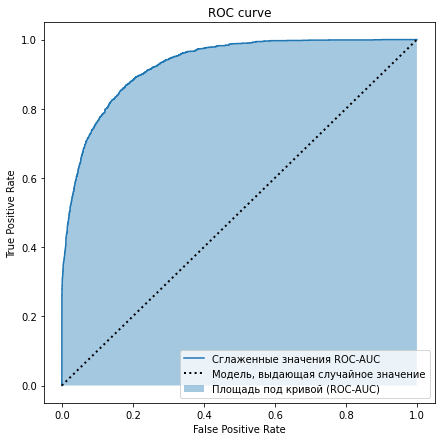

In [ ]:
# создаём график
plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates, 
         label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
         label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates, true_positive_rates, step="pre", 
                 alpha=0.4, label='Площадь под кривой (ROC-AUC)')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc = roc_auc_score(y_test, pred_proba_boosting).round(3)

In [ ]:
print("ROC-AUC на тестовой выборке:", roc_auc_score(y_test, pred_proba_boosting).round(3)) 

ROC-AUC на тестовой выборке: 0.928


In [ ]:
experiment.log_metric('roc_auc OneHot data', roc_auc)

In [ ]:
pred_proba_boosting_le = boosting_tree_model_le.predict_proba(X_test_new)

In [ ]:
pred_proba_boosting = pred_proba_boosting_le[:, 1]

In [ ]:
roc_auc = roc_auc_score(y_test, pred_proba_boosting).round(3)
roc_auc